## Problem Statement

Our goal is to look at transcripts of various comedians and note their similarities and differences. Specifically, I'd like to know if Ali Wong's comedy style is different than other comedians, since she's the comedian that got me interested in stand up comedy.

# Data Cleaning

## Introduction

This notebook goes through a necessary step of any data science project - data cleaning. Data cleaning is a time consuming and unenjoyable task, yet it's a very important one. Keep in mind, "garbage in, garbage out". Feeding dirty data into a model will give us results that are meaningless.

Specifically, we'll be walking through:

1. **Getting the data - **in this case, we'll be scraping data from a website
2. **Cleaning the data - **we will walk through popular text pre-processing techniques
3. **Organizing the data - **we will organize the cleaned data into a way that is easy to input into other algorithms

The output of this notebook will be clean, organized data in two standard text formats:

1. **Corpus** - a collection of text
2. **Document-Term Matrix** - word counts in matrix format

## Getting The Data

Luckily, there are wonderful people online that keep track of stand up routine transcripts. [Scraps From The Loft](http://scrapsfromtheloft.com) makes them available for non-profit and educational purposes.

To decide which comedians to look into, I went on IMDB and looked specifically at comedy specials that were released in the past 5 years. To narrow it down further, I looked only at those with greater than a 7.5/10 rating and more than 2000 votes. If a comedian had multiple specials that fit those requirements, I would pick the most highly rated one. I ended up with a dozen comedy specials.

In [128]:
# Web scraping, pickle imports
import requests
from bs4 import BeautifulSoup
import pickle

# Scrapes transcript data from scrapsfromtheloft.com
def url_to_transcript(url):
    '''Returns transcript data specifically from scrapsfromtheloft.com.'''
    page = requests.get(url).text
    soup = BeautifulSoup(page, "lxml")
    text = [p.text for p in soup.find(class_="elementor-widget-theme-post-content").find_all('p')]
    print(url)
    return text

# URLs of transcripts in scope
urls = ['http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/',
        'http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/',
        'http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/',
        'http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/',
        'http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/',
        'http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/',
        'http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/19/joe-rogan-triggered-2016-full-transcript/']

# Comedian names
comedians = ['louis', 'dave', 'ricky', 'bill', 'jim', 'john', 'ali', 'anthony', 'mike', 'joe']

In [129]:
# Actually request transcripts (takes a few minutes to run)
transcripts = [url_to_transcript(u) for u in urls]

http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/
http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/
http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/
http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/
http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/
http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/
http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/
http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/
http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/
http://scrapsfromtheloft.com/2017/08/19/joe-rogan-triggered-2016-full-transcript/


In [130]:
# Pickle files for later use

# Make a new directory to hold the text files
!mkdir transcripts

for i, c in enumerate(comedians):
     with open("transcripts/" + c + ".txt", "wb") as file:
        pickle.dump(transcripts[i], file)

mkdir: cannot create directory ‘transcripts’: File exists


In [131]:
# Load pickled files
data = {}
for i, c in enumerate(comedians):
    with open("transcripts/" + c + ".txt", "rb") as file:
        data[c] = pickle.load(file)

In [132]:
# Double check to make sure data has been loaded properly
data.keys()

dict_keys(['louis', 'dave', 'ricky', 'bill', 'jim', 'john', 'ali', 'anthony', 'mike', 'joe'])

In [133]:
# More checks
data['louis'][:2]

['Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily agree with you, but I appreciate very much. Well, this is a nice place. This is easily the nicest place For many miles in every direction. That’s how you compliment a building And shit on a town with one sentence. It is odd around here, as I was driving here. There doesn’t seem to be any difference Between the sidewalk and the street for pedestrians here. People just kind of walk in the middle of the road. I love traveling And seeing all the different parts of the country. I live in New York. I live in a– There’s no value to your doing that at all.',
 '“The Old Lady And The Dog”\nI live– I live in New York. I always– Like, there’s this old lady in my neighborhood, And she’s always walking her dog. She’s always just– she’s very old. She just stands there just being old, And the dog just fights gravity every day, just– The two of them, it’s re

## Cleaning The Data

When dealing with numerical data, data cleaning often involves removing null values and duplicate data, dealing with outliers, etc. With text data, there are some common data cleaning techniques, which are also known as text pre-processing techniques.

With text data, this cleaning process can go on forever. There's always an exception to every cleaning step. So, we're going to follow the MVP (minimum viable product) approach - start simple and iterate. Here are a bunch of things you can do to clean your data. We're going to execute just the common cleaning steps here and the rest can be done at a later point to improve our results.

**Common data cleaning steps on all text:**
* Make text all lower case
* Remove punctuation
* Remove numerical values
* Remove common non-sensical text (/n)
* Tokenize text
* Remove stop words

**More data cleaning steps after tokenization:**
* Stemming / lemmatization
* Parts of speech tagging
* Create bi-grams or tri-grams
* Deal with typos
* And more...

In [134]:
# Let's take a look at our data again
next(iter(data.keys()))

'louis'

In [135]:
# Notice that our dictionary is currently in key: comedian, value: list of text format
next(iter(data.values()))

['Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily agree with you, but I appreciate very much. Well, this is a nice place. This is easily the nicest place For many miles in every direction. That’s how you compliment a building And shit on a town with one sentence. It is odd around here, as I was driving here. There doesn’t seem to be any difference Between the sidewalk and the street for pedestrians here. People just kind of walk in the middle of the road. I love traveling And seeing all the different parts of the country. I live in New York. I live in a– There’s no value to your doing that at all.',
 '“The Old Lady And The Dog”\nI live– I live in New York. I always– Like, there’s this old lady in my neighborhood, And she’s always walking her dog. She’s always just– she’s very old. She just stands there just being old, And the dog just fights gravity every day, just– The two of them, it’s re

In [136]:
# We are going to change this to key: comedian, value: string format
def combine_text(list_of_text):
    '''Takes a list of text and combines them into one large chunk of text.'''
    combined_text = ' '.join(list_of_text)
    return combined_text

In [137]:
# Combine it!
data_combined = {key: [combine_text(value)] for (key, value) in data.items()}

In [138]:
# We can either keep it in dictionary format or put it into a pandas dataframe
import pandas as pd
pd.set_option('max_colwidth',150)

data_df = pd.DataFrame.from_dict(data_combined).transpose()
data_df.columns = ['transcript']
data_df = data_df.sort_index()
data_df

,transcript
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ..."
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s..."
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ..."
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ..."
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello..."
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ..."
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m..."
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ..."
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...


In [139]:
# Let's take a look at the transcript for Ali Wong
data_df.transcript.loc['ali']

"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have to get this shit over with, ’cause I have to pee in, like, ten minutes. But thank you, everybody, so much for coming. Um… It’s a very exciting day for me. It’s been a very exciting year for me. I turned 33 this year. Yes! Thank you, five people. I appreciate that. Uh, I can tell that I’m getting older, because, now, when I see an 18-year-old girl, my automatic thought… is “Fuck you.” “Fuck you. I don’t even know you, but fuck you!” ‘Cause I’m straight up jealous. I’m jealous, first and foremost, of their metabolism. Because 18-year-old girls, they could just eat like shit, and then they take a shit and have a six-pack, right? They got that-that beautiful inner thigh clearance where they put their feet together and there’s that huge gap here with the light of potential just radiating through.\nAnd then, when they go to sleep, they just go to 

In [140]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [141]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_df.transcript.apply(round1))
data_clean

,transcript
ali,ladies and gentlemen please welcome to the stage ali wong hi hello welcome thank you thank you for coming hello hello we are gonna have to get thi...
anthony,thank you thank you thank you san francisco thank you so much so good to be here people were surprised when i told ’em i was gonna tape my special...
bill,all right thank you thank you very much thank you thank you thank you how are you what’s going on thank you it’s a pleasure to be here in the gre...
dave,this is dave he tells dirty jokes for a living that stare is where most of his hard work happens it signifies a profound train of thought the alch...
jim,ladies and gentlemen please welcome to the stage mr jim jefferies hello sit down sit down sit down sit down sit down thank you boston i appre...
joe,ladies and gentlemen welcome joe rogan what the fck is going on san francisco thanks for coming i appreciate it god damn put your phone down f...
john,armed with boyish charm and a sharp wit the former “snl” writer john mulaney offers sly takes on marriage his beef with babies and the time he met...
louis,intro\nfade the music out let’s roll hold there lights do the lights thank you thank you very much i appreciate that i don’t necessarily agree wit...
mike,wow hey thank you thanks thank you guys hey seattle nice to see you look at this look at us we’re here this is crazy it’s insane so about five yea...
ricky,hello hello how you doing great thank you wow calm down shut the fuck up thank you what a lovely welcome i’m gonna try my hardest tonight you’re t...


In [142]:
# Apply a second round of cleaning
def clean_text_round2(text):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

round2 = lambda x: clean_text_round2(x)

In [143]:
# Let's take a look at the updated text
data_clean = pd.DataFrame(data_clean.transcript.apply(round2))
data_clean

,transcript
ali,ladies and gentlemen please welcome to the stage ali wong hi hello welcome thank you thank you for coming hello hello we are gonna have to get thi...
anthony,thank you thank you thank you san francisco thank you so much so good to be here people were surprised when i told em i was gonna tape my special ...
bill,all right thank you thank you very much thank you thank you thank you how are you whats going on thank you its a pleasure to be here in the great...
dave,this is dave he tells dirty jokes for a living that stare is where most of his hard work happens it signifies a profound train of thought the alch...
jim,ladies and gentlemen please welcome to the stage mr jim jefferies hello sit down sit down sit down sit down sit down thank you boston i appre...
joe,ladies and gentlemen welcome joe rogan what the fck is going on san francisco thanks for coming i appreciate it god damn put your phone down f...
john,armed with boyish charm and a sharp wit the former snl writer john mulaney offers sly takes on marriage his beef with babies and the time he met b...
louis,introfade the music out lets roll hold there lights do the lights thank you thank you very much i appreciate that i dont necessarily agree with yo...
mike,wow hey thank you thanks thank you guys hey seattle nice to see you look at this look at us were here this is crazy its insane so about five years...
ricky,hello hello how you doing great thank you wow calm down shut the fuck up thank you what a lovely welcome im gonna try my hardest tonight youre thi...


**NOTE:** This data cleaning aka text pre-processing step could go on for a while, but we are going to stop for now. After going through some analysis techniques, if you see that the results don't make sense or could be improved, you can come back and make more edits such as:
* Mark 'cheering' and 'cheer' as the same word (stemming / lemmatization)
* Combine 'thank you' into one term (bi-grams)
* And a lot more...

## Organizing The Data

I mentioned earlier that the output of this notebook will be clean, organized data in two standard text formats:
1. **Corpus - **a collection of text
2. **Document-Term Matrix - **word counts in matrix format

### Corpus

We already created a corpus in an earlier step. The definition of a corpus is a collection of texts, and they are all put together neatly in a pandas dataframe here.

In [144]:
# Let's take a look at our dataframe
data_df

,transcript
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ..."
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s..."
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ..."
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ..."
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello..."
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ..."
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m..."
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ..."
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...


In [145]:
# Let's add the comedians' full names as well
full_names = ['Ali Wong', 'Anthony Jeselnik', 'Bill Burr', 'Dave Chappelle',
              'Jim Jefferies', 'Joe Rogan', 'John Mulaney', 'Louis C.K.', 'Mike Birbiglia', 'Ricky Gervais']

data_df['full_name'] = full_names
data_df

,transcript,full_name
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ...",Ali Wong
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s...",Anthony Jeselnik
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ...",Bill Burr
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ...",Dave Chappelle
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello...",Jim Jefferies
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ...",Joe Rogan
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m...",John Mulaney
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...,Louis C.K.
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ...",Mike Birbiglia
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...,Ricky Gervais


In [146]:
# Let's pickle it for later use
data_df.to_pickle("corpus.pkl")

### Document-Term Matrix

For many of the techniques we'll be using in future notebooks, the text must be tokenized, meaning broken down into smaller pieces. The most common tokenization technique is to break down text into words. We can do this using scikit-learn's CountVectorizer, where every row will represent a different document and every column will represent a different word.

In addition, with CountVectorizer, we can remove stop words. Stop words are common words that add no additional meaning to text such as 'a', 'the', etc.

In [147]:
# We are going to create a document-term matrix using CountVectorizer, and exclude common English stop words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
data_cv = cv.fit_transform(data_clean.transcript)
data_dtm = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_dtm.index = data_clean.index
data_dtm

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaaah,aaah,aah,abc,abcs,ability,abject,able,ablebodied,abortion,abortions,abroad,absolute,absolutely,absorb,absorbing,abuse,abused,accent,accents,accept,acceptable,accepted,access,accident,accidentally,accomplished,according,accoutrements,accurate,accustomed,achieve,achievement,acid,acknowledge,acknowledging,acquitted,act,acting,actions,...,year,years,yecch,yell,yelled,yelling,yellow,yelp,yep,yes,yesterday,yo,yoga,yoko,yolanda,yolo,york,youd,youi,youll,young,younger,youngest,youre,youth,youtube,youve,yulin,yummy,yyou,ze,zealand,zeppelin,zero,zillion,zombie,zombies,zoning,zoo,éclair
ali,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,1,1,0,2,0,0,0,2,0,0,0,0,0,1,0,0,...,7,5,0,0,0,1,0,1,0,9,0,0,1,1,0,1,0,0,1,4,2,0,0,31,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0
anthony,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,7,5,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,19,0,0,6,0,0,0,0,10,0,0,0,0,0,0,0,0
bill,1,0,0,0,1,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,4,0,0,...,3,18,0,0,2,0,1,0,0,3,0,0,1,0,0,0,1,1,0,5,0,0,0,59,0,1,1,0,1,0,1,0,0,1,1,1,1,1,0,0
dave,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,1,4,0,1,...,2,9,0,1,0,0,0,0,0,7,0,1,0,0,0,0,1,7,0,3,10,0,0,15,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
jim,0,0,0,0,0,0,0,1,2,0,0,3,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,...,3,6,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,2,0,2,0,0,0,48,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0
joe,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,3,6,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,4,0,1,42,0,3,6,0,0,0,0,0,0,0,0,0,0,0,0,0
john,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,2,11,0,0,1,1,1,0,0,11,0,0,0,0,0,0,7,2,0,1,2,1,0,28,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1
louis,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,3,4,2,0,1,0,0,0,1,12,0,0,0,0,0,0,4,2,0,1,8,3,0,50,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0
mike,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,2,8,0,0,0,0,0,0,0,2,1,0,0,0,0,0,5,3,0,0,1,0,0,28,0,0,3,0,0,0,0,0,2,1,0,0,0,0,0,0
ricky,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,...,10,24,0,0,0,0,0,0,2,14,0,1,0,0,0,0,0,0,0,2,2,0,1,41,0,1,10,1,1,0,0,0,0,0,0,0,0,0,1,0


In [148]:
# Let's pickle it for later use
data_dtm.to_pickle("dtm.pkl")

In [149]:
# Let's also pickle the cleaned data (before we put it in document-term matrix format) and the CountVectorizer object
data_clean.to_pickle('data_clean.pkl')
pickle.dump(cv, open("cv.pkl", "wb"))

# Exploratory Data Analysis

## Introduction

After the data cleaning step where we put our data into a few standard formats, the next step is to take a look at the data and see if what we're looking at makes sense. Before applying any fancy algorithms, it's always important to explore the data first.

When working with numerical data, some of the exploratory data analysis (EDA) techniques we can use include finding the average of the data set, the distribution of the data, the most common values, etc. The idea is the same when working with text data. We are going to find some more obvious patterns with EDA before identifying the hidden patterns with machines learning (ML) techniques. We are going to look at the following for each comedian:

1. **Most common words** - find these and create word clouds
2. **Size of vocabulary** - look number of unique words and also how quickly someone speaks
3. **Amount of profanity** - most common terms

## Most Common Words

### Analysis

In [150]:
# Read in the document-term matrix
import pandas as pd

data = pd.read_pickle('dtm.pkl')
data = data.transpose()
data.head()

,ali,anthony,bill,dave,jim,joe,john,louis,mike,ricky
aaaaah,0,0,1,0,0,0,0,0,0,0
aaah,0,0,0,1,0,0,0,0,0,0
aah,0,0,0,0,0,0,0,3,0,0
abc,1,0,0,0,0,0,0,0,0,0
abcs,0,0,1,0,0,0,0,0,0,0


In [151]:
# Find the top 30 words said by each comedian
top_dict = {}
for c in data.columns:
    top = data[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'ali': [('like', 126),
  ('im', 74),
  ('know', 65),
  ('just', 64),
  ('dont', 61),
  ('shit', 34),
  ('thats', 34),
  ('youre', 31),
  ('gonna', 28),
  ('ok', 26),
  ('lot', 24),
  ('oh', 21),
  ('gotta', 21),
  ('wanna', 21),
  ('husband', 20),
  ('right', 19),
  ('got', 19),
  ('time', 19),
  ('cause', 18),
  ('day', 17),
  ('women', 17),
  ('people', 16),
  ('pregnant', 15),
  ('hes', 14),
  ('need', 14),
  ('god', 14),
  ('tell', 13),
  ('yeah', 13),
  ('work', 12),
  ('theyre', 12)],
 'anthony': [('im', 60),
  ('like', 50),
  ('know', 39),
  ('dont', 38),
  ('joke', 34),
  ('got', 34),
  ('said', 31),
  ('thats', 31),
  ('anthony', 27),
  ('day', 26),
  ('say', 26),
  ('just', 26),
  ('guys', 23),
  ('people', 22),
  ('youre', 19),
  ('tell', 19),
  ('right', 18),
  ('grandma', 18),
  ('thing', 17),
  ('think', 17),
  ('time', 17),
  ('jokes', 16),
  ('did', 16),
  ('yeah', 16),
  ('school', 16),
  ('good', 16),
  ('gonna', 15),
  ('ive', 15),
  ('baby', 15),
  ('okay', 15)],
 

In [152]:
# Print the top 15 words said by each comedian
for comedian, top_words in top_dict.items():
    print(comedian)
    print(', '.join([word for word, count in top_words[0:14]]))
    print('---')

ali
like, im, know, just, dont, shit, thats, youre, gonna, ok, lot, oh, gotta, wanna
---
anthony
im, like, know, dont, joke, got, said, thats, anthony, day, say, just, guys, people
---
bill
like, just, right, im, know, dont, gonna, got, fucking, yeah, shit, youre, thats, dude
---
dave
like, know, said, just, im, shit, people, didnt, dont, ahah, time, fuck, thats, fucking
---
jim
like, im, dont, right, fucking, went, just, know, youre, people, thats, day, oh, think
---
joe
like, people, just, dont, fcking, im, fck, thats, gonna, theyre, know, youre, think, shit
---
john
like, know, just, dont, said, clinton, im, thats, right, youre, little, time, hey, got
---
louis
like, just, know, dont, thats, im, youre, life, people, thing, gonna, hes, cause, theres
---
mike
like, im, know, said, just, dont, thats, think, says, cause, right, jenny, goes, really
---
ricky
right, like, just, im, dont, know, said, yeah, fucking, got, say, youre, went, id
---


**NOTE:** At this point, we could go on and create word clouds. However, by looking at these top words, you can see that some of them have very little meaning and could be added to a stop words list, so let's do just that.



In [153]:
# Look at the most common top words --> add them to the stop word list
from collections import Counter

# Let's first pull out the top 30 words for each comedian
words = []
for comedian in data.columns:
    top = [word for (word, count) in top_dict[comedian]]
    for t in top:
        words.append(t)
        
words

['like',
 'im',
 'know',
 'just',
 'dont',
 'shit',
 'thats',
 'youre',
 'gonna',
 'ok',
 'lot',
 'oh',
 'gotta',
 'wanna',
 'husband',
 'right',
 'got',
 'time',
 'cause',
 'day',
 'women',
 'people',
 'pregnant',
 'hes',
 'need',
 'god',
 'tell',
 'yeah',
 'work',
 'theyre',
 'im',
 'like',
 'know',
 'dont',
 'joke',
 'got',
 'said',
 'thats',
 'anthony',
 'day',
 'say',
 'just',
 'guys',
 'people',
 'youre',
 'tell',
 'right',
 'grandma',
 'thing',
 'think',
 'time',
 'jokes',
 'did',
 'yeah',
 'school',
 'good',
 'gonna',
 'ive',
 'baby',
 'okay',
 'like',
 'just',
 'right',
 'im',
 'know',
 'dont',
 'gonna',
 'got',
 'fucking',
 'yeah',
 'shit',
 'youre',
 'thats',
 'dude',
 'think',
 'want',
 'fuck',
 'people',
 'did',
 'hes',
 'guy',
 'didnt',
 'make',
 'come',
 'thing',
 'going',
 'theyre',
 'theres',
 'let',
 'doing',
 'like',
 'know',
 'said',
 'just',
 'im',
 'shit',
 'people',
 'didnt',
 'dont',
 'ahah',
 'time',
 'fuck',
 'thats',
 'fucking',
 'black',
 'man',
 'good',
 'g

In [154]:
# Let's aggregate this list and identify the most common words along with how many routines they occur in
Counter(words).most_common()

[('like', 10),
 ('im', 10),
 ('know', 10),
 ('just', 10),
 ('dont', 10),
 ('thats', 10),
 ('right', 10),
 ('people', 10),
 ('youre', 9),
 ('got', 9),
 ('gonna', 8),
 ('think', 7),
 ('time', 6),
 ('cause', 6),
 ('hes', 6),
 ('yeah', 6),
 ('theyre', 6),
 ('said', 6),
 ('shit', 5),
 ('oh', 5),
 ('day', 5),
 ('say', 5),
 ('thing', 5),
 ('theres', 5),
 ('really', 5),
 ('good', 4),
 ('fucking', 4),
 ('fuck', 4),
 ('didnt', 4),
 ('going', 4),
 ('did', 3),
 ('ive', 3),
 ('want', 3),
 ('went', 3),
 ('ok', 2),
 ('lot', 2),
 ('gotta', 2),
 ('women', 2),
 ('tell', 2),
 ('joke', 2),
 ('guys', 2),
 ('dude', 2),
 ('guy', 2),
 ('make', 2),
 ('come', 2),
 ('man', 2),
 ('goes', 2),
 ('kids', 2),
 ('real', 2),
 ('life', 2),
 ('little', 2),
 ('old', 2),
 ('mean', 2),
 ('id', 2),
 ('wanna', 1),
 ('husband', 1),
 ('pregnant', 1),
 ('need', 1),
 ('god', 1),
 ('work', 1),
 ('anthony', 1),
 ('grandma', 1),
 ('jokes', 1),
 ('school', 1),
 ('baby', 1),
 ('okay', 1),
 ('let', 1),
 ('doing', 1),
 ('ahah', 1),
 ('b

In [155]:
# If more than half of the comedians have it as a top word, exclude it from the list
add_stop_words = [word for word, count in Counter(words).most_common() if count > 6]
add_stop_words

['like',
 'im',
 'know',
 'just',
 'dont',
 'thats',
 'right',
 'people',
 'youre',
 'got',
 'gonna',
 'think']

In [156]:
# Let's update our document-term matrix with the new list of stop words
from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer

# Read in cleaned data
data_clean = pd.read_pickle('data_clean.pkl')

# Add new stop words
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words)
data_cv = cv.fit_transform(data_clean.transcript)
data_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_stop.index = data_clean.index

# Pickle it for later use
import pickle
pickle.dump(cv, open("cv_stop.pkl", "wb"))
data_stop.to_pickle("dtm_stop.pkl")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [157]:
# Let's make some word clouds!
# Terminal / Anaconda Prompt: conda install -c conda-forge wordcloud
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

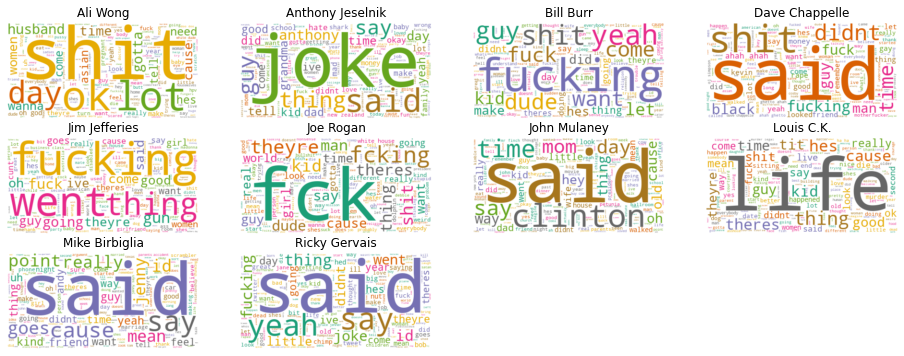

In [158]:
# Reset the output dimensions
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 6]

full_names = ['Ali Wong', 'Anthony Jeselnik', 'Bill Burr', 'Dave Chappelle',
              'Jim Jefferies', 'Joe Rogan', 'John Mulaney', 'Louis C.K.', 'Mike Birbiglia', 'Ricky Gervais']

# Create subplots for each comedian
for index, comedian in enumerate(data.columns):
    wc.generate(data_clean.transcript[comedian])
    
    plt.subplot(3, 4, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(full_names[index])
    
plt.show()

### Findings

* Ali Wong says the s-word a lot and talks about her husband. I guess that's funny to me.
* A lot of people use the F-word. Let's dig into that later.

## Number of Words

### Analysis

In [159]:
# Find the number of unique words that each comedian uses

# Identify the non-zero items in the document-term matrix, meaning that the word occurs at least once
unique_list = []
for comedian in data.columns:
    uniques = data[comedian].to_numpy().nonzero()[0].size
    unique_list.append(uniques)

# Create a new dataframe that contains this unique word count
data_words = pd.DataFrame(list(zip(full_names, unique_list)), columns=['comedian', 'unique_words'])
data_unique_sort = data_words.sort_values(by='unique_words')
data_unique_sort

,comedian,unique_words
1,Anthony Jeselnik,983
7,Louis C.K.,1098
4,Jim Jefferies,1313
0,Ali Wong,1341
3,Dave Chappelle,1385
6,John Mulaney,1399
5,Joe Rogan,1434
8,Mike Birbiglia,1494
2,Bill Burr,1633
9,Ricky Gervais,1633


In [160]:
# Calculate the words per minute of each comedian

# Find the total number of words that a comedian uses
total_list = []
for comedian in data.columns:
    totals = sum(data[comedian])
    total_list.append(totals)
    
# Comedy special run times from IMDB, in minutes
run_times = [60, 59, 80, 67, 73, 77, 62, 58, 76, 79]

# Let's add some columns to our dataframe
data_words['total_words'] = total_list
data_words['run_times'] = run_times
data_words['words_per_minute'] = data_words['total_words'] / data_words['run_times']

# Sort the dataframe by words per minute to see who talks the slowest and fastest
data_wpm_sort = data_words.sort_values(by='words_per_minute')
data_wpm_sort

,comedian,unique_words,total_words,run_times,words_per_minute
1,Anthony Jeselnik,983,2905,59,49.237288
0,Ali Wong,1341,3283,60,54.716667
7,Louis C.K.,1098,3332,58,57.448276
5,Joe Rogan,1434,4579,77,59.467532
3,Dave Chappelle,1385,4065,67,60.671642
8,Mike Birbiglia,1494,4741,76,62.381579
9,Ricky Gervais,1633,4972,79,62.936709
6,John Mulaney,1399,4019,62,64.822581
4,Jim Jefferies,1313,4764,73,65.260274
2,Bill Burr,1633,5535,80,69.187500


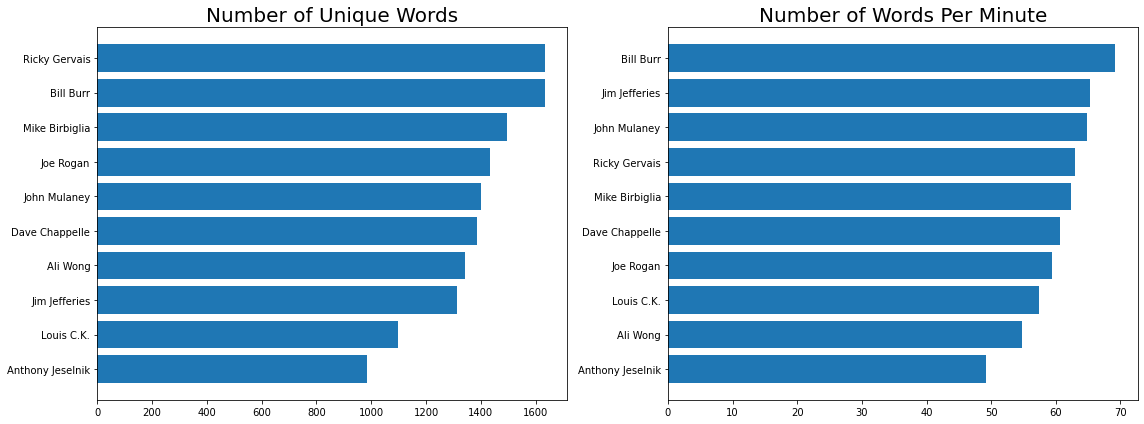

In [161]:
# Let's plot our findings
import numpy as np

y_pos = np.arange(len(data_words))

plt.subplot(1, 2, 1)
plt.barh(y_pos, data_unique_sort.unique_words, align='center')
plt.yticks(y_pos, data_unique_sort.comedian)
plt.title('Number of Unique Words', fontsize=20)

plt.subplot(1, 2, 2)
plt.barh(y_pos, data_wpm_sort.words_per_minute, align='center')
plt.yticks(y_pos, data_wpm_sort.comedian)
plt.title('Number of Words Per Minute', fontsize=20)

plt.tight_layout()
plt.show()

### Findings

* **Vocabulary**
   * Ricky Gervais (British comedy) and Bill Burr (podcast host) use a lot of words in their comedy
   * Louis C.K. (self-depricating comedy) and Anthony Jeselnik (dark humor) have a smaller vocabulary


* **Talking Speed**
   * Joe Rogan (blue comedy) and Bill Burr (podcast host) talk fast
   * Bo Burnham (musical comedy) and Anthony Jeselnik (dark humor) talk slow
   
Ali Wong is somewhere in the middle in both cases. Nothing too interesting here.

## Amount of Profanity

### Analysis

In [162]:
# Earlier I said we'd revisit profanity. Let's take a look at the most common words again.
Counter(words).most_common()

[('like', 10),
 ('im', 10),
 ('know', 10),
 ('just', 10),
 ('dont', 10),
 ('thats', 10),
 ('right', 10),
 ('people', 10),
 ('youre', 9),
 ('got', 9),
 ('gonna', 8),
 ('think', 7),
 ('time', 6),
 ('cause', 6),
 ('hes', 6),
 ('yeah', 6),
 ('theyre', 6),
 ('said', 6),
 ('shit', 5),
 ('oh', 5),
 ('day', 5),
 ('say', 5),
 ('thing', 5),
 ('theres', 5),
 ('really', 5),
 ('good', 4),
 ('fucking', 4),
 ('fuck', 4),
 ('didnt', 4),
 ('going', 4),
 ('did', 3),
 ('ive', 3),
 ('want', 3),
 ('went', 3),
 ('ok', 2),
 ('lot', 2),
 ('gotta', 2),
 ('women', 2),
 ('tell', 2),
 ('joke', 2),
 ('guys', 2),
 ('dude', 2),
 ('guy', 2),
 ('make', 2),
 ('come', 2),
 ('man', 2),
 ('goes', 2),
 ('kids', 2),
 ('real', 2),
 ('life', 2),
 ('little', 2),
 ('old', 2),
 ('mean', 2),
 ('id', 2),
 ('wanna', 1),
 ('husband', 1),
 ('pregnant', 1),
 ('need', 1),
 ('god', 1),
 ('work', 1),
 ('anthony', 1),
 ('grandma', 1),
 ('jokes', 1),
 ('school', 1),
 ('baby', 1),
 ('okay', 1),
 ('let', 1),
 ('doing', 1),
 ('ahah', 1),
 ('b

In [163]:
# Let's isolate just these bad words
data_bad_words = data.transpose()[['fucking', 'fuck', 'shit']]
data_profanity = pd.concat([data_bad_words.fucking + data_bad_words.fuck, data_bad_words.shit], axis=1)
data_profanity.columns = ['f_word', 's_word']
data_profanity

,f_word,s_word
ali,16,34
anthony,15,9
bill,106,63
dave,65,46
jim,115,20
joe,0,40
john,4,6
louis,21,25
mike,0,0
ricky,60,6


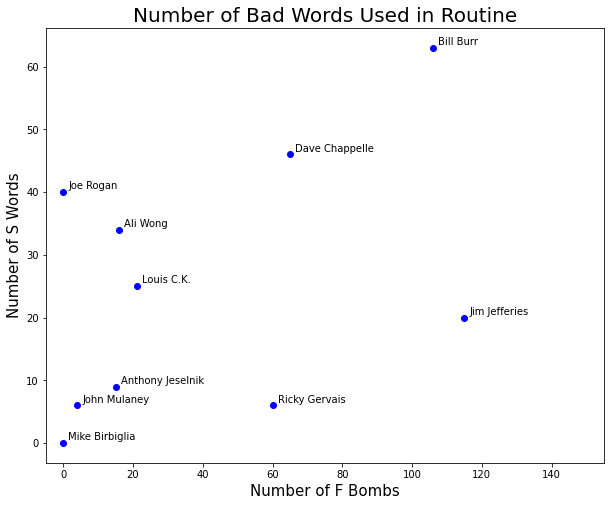

In [164]:
# Let's create a scatter plot of our findings
plt.rcParams['figure.figsize'] = [10, 8]

for i, comedian in enumerate(data_profanity.index):
    x = data_profanity.f_word.loc[comedian]
    y = data_profanity.s_word.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+1.5, y+0.5, full_names[i], fontsize=10)
    plt.xlim(-5, 155) 
    
plt.title('Number of Bad Words Used in Routine', fontsize=20)
plt.xlabel('Number of F Bombs', fontsize=15)
plt.ylabel('Number of S Words', fontsize=15)

plt.show()

### Findings

* **Averaging 2 F-Bombs Per Minute!** - I don't like too much swearing, especially the f-word, which is probably why I've never heard of Bill Bur, Joe Rogan and Jim Jefferies.
* **Clean Humor** - It looks like profanity might be a good predictor of the type of comedy I like. Besides Ali Wong, my two other favorite comedians in this group are John Mulaney and Mike Birbiglia.

## Side Note

What was our goal for the EDA portion of our journey? **To be able to take an initial look at our data and see if the results of some basic analysis made sense.**

My conclusion - yes, it does, for a first pass. There are definitely some things that could be better cleaned up, such as adding more stop words or including bi-grams. But we can save that for another day. The results, especially the profanity findings, are interesting and make general sense, so we're going to move on.

As a reminder, the data science process is an interative one. It's better to see some non-perfect but acceptable results to help you quickly decide whether your project is a dud or not, instead of having analysis paralysis and never delivering anything.

**Alice's data science (and life) motto: Let go of perfectionism!**

# Sentiment Analysis

## Introduction

So far, all of the analysis we've done has been pretty generic - looking at counts, creating scatter plots, etc. These techniques could be applied to numeric data as well.

When it comes to text data, there are a few popular techniques that we'll be going through in the next few notebooks, starting with sentiment analysis. A few key points to remember with sentiment analysis.

1. **TextBlob Module:** Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels.
2. **Sentiment Labels:** Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these.
   * **Polarity**: How positive or negative a word is. -1 is very negative. +1 is very positive.
   * **Subjectivity**: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.

For more info on how TextBlob coded up its [sentiment function](https://planspace.org/20150607-textblob_sentiment/).

Let's take a look at the sentiment of the various transcripts, both overall and throughout the comedy routine.

## Sentiment of Routine

In [165]:
# We'll start by reading in the corpus, which preserves word order
import pandas as pd

data = pd.read_pickle('corpus.pkl')
data

,transcript,full_name
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ...",Ali Wong
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s...",Anthony Jeselnik
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ...",Bill Burr
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ...",Dave Chappelle
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello...",Jim Jefferies
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ...",Joe Rogan
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m...",John Mulaney
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...,Louis C.K.
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ...",Mike Birbiglia
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...,Ricky Gervais


In [166]:
# Create quick lambda functions to find the polarity and subjectivity of each routine
# Terminal / Anaconda Navigator: conda install -c conda-forge textblob
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

data['polarity'] = data['transcript'].apply(pol)
data['subjectivity'] = data['transcript'].apply(sub)
data

,transcript,full_name,polarity,subjectivity
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ...",Ali Wong,0.069359,0.482403
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s...",Anthony Jeselnik,0.054285,0.559732
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ...",Bill Burr,0.016479,0.537016
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ...",Dave Chappelle,-0.004069,0.513958
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello...",Jim Jefferies,0.044224,0.523382
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ...",Joe Rogan,0.039378,0.547370
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m...",John Mulaney,0.081962,0.483122
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...,Louis C.K.,0.056665,0.515796
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ...",Mike Birbiglia,0.092927,0.518476
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...,Ricky Gervais,0.066489,0.497313


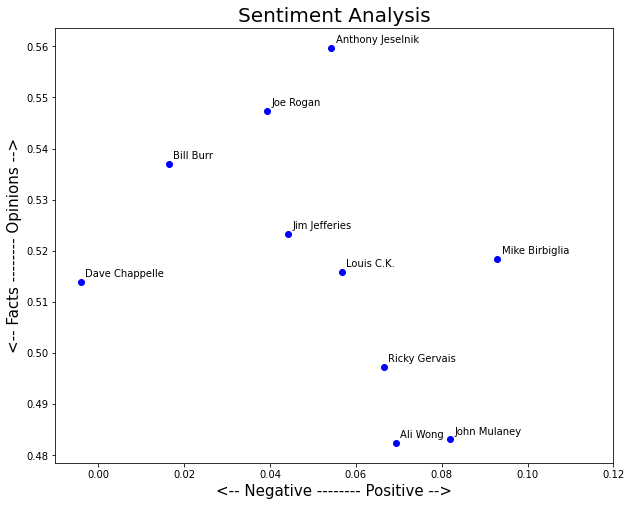

In [167]:
# Let's plot the results
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(data.index):
    x = data.polarity.loc[comedian]
    y = data.subjectivity.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, data['full_name'][index], fontsize=10)
    plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

## Sentiment of Routine Over Time

Instead of looking at the overall sentiment, let's see if there's anything interesting about the sentiment over time throughout each routine.

In [168]:
# Split each routine into 10 parts
import numpy as np
import math

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [169]:
# Let's take a look at our data again
data

,transcript,full_name,polarity,subjectivity
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ...",Ali Wong,0.069359,0.482403
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s...",Anthony Jeselnik,0.054285,0.559732
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ...",Bill Burr,0.016479,0.537016
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ...",Dave Chappelle,-0.004069,0.513958
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello...",Jim Jefferies,0.044224,0.523382
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ...",Joe Rogan,0.039378,0.547370
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m...",John Mulaney,0.081962,0.483122
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...,Louis C.K.,0.056665,0.515796
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ...",Mike Birbiglia,0.092927,0.518476
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...,Ricky Gervais,0.066489,0.497313


In [170]:
# Let's create a list to hold all of the pieces of text
list_pieces = []
for t in data.transcript:
    split = split_text(t)
    list_pieces.append(split)
    
list_pieces

[['Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have to get this shit over with, ’cause I have to pee in, like, ten minutes. But thank you, everybody, so much for coming. Um… It’s a very exciting day for me. It’s been a very exciting year for me. I turned 33 this year. Yes! Thank you, five people. I appreciate that. Uh, I can tell that I’m getting older, because, now, when I see an 18-year-old girl, my automatic thought… is “Fuck you.” “Fuck you. I don’t even know you, but fuck you!” ‘Cause I’m straight up jealous. I’m jealous, first and foremost, of their metabolism. Because 18-year-old girls, they could just eat like shit, and then they take a shit and have a six-pack, right? They got that-that beautiful inner thigh clearance where they put their feet together and there’s that huge gap here with the light of potential just radiating through.\nAnd then, when they go to sleep, they just go t

In [171]:
# The list has 10 elements, one for each transcript
len(list_pieces)

10

In [172]:
# Each transcript has been split into 10 pieces of text
len(list_pieces[0])

10

In [173]:
# Calculate the polarity for each piece of text

polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)
    
polarity_transcript

[[0.11168482647296207,
  0.056407029478458055,
  0.09445691155249979,
  0.09236886724386723,
  -0.014671592775041055,
  0.09538361348808912,
  0.06079713127248339,
  0.08721655328798185,
  0.030089690638160044,
  0.07351994851994852],
 [0.13933883477633482,
  -0.06333451704545455,
  -0.056153799903799935,
  0.014602659245516405,
  0.16377334420812684,
  0.09091338259441709,
  0.09420031055900621,
  0.11566683919944787,
  -0.05070608684245053,
  0.058467487373737366],
 [-0.0326152022580594,
  0.006825656825656827,
  0.023452001215159095,
  0.01934081890331888,
  -0.026312183887941466,
  0.06207506613756614,
  0.030250682288725742,
  -0.020351594027441484,
  -0.01150485008818343,
  0.10757491470108295],
 [-0.05093449586407334,
  -0.07101471980837788,
  0.035829891691960644,
  0.08313791054959534,
  -0.026718682968682954,
  0.09782737058599124,
  -0.12493321942974718,
  -0.08041766347687401,
  -0.06019759281122916,
  0.15191938178780284],
 [0.09480343501984131,
  0.10371625923096511,
  0.

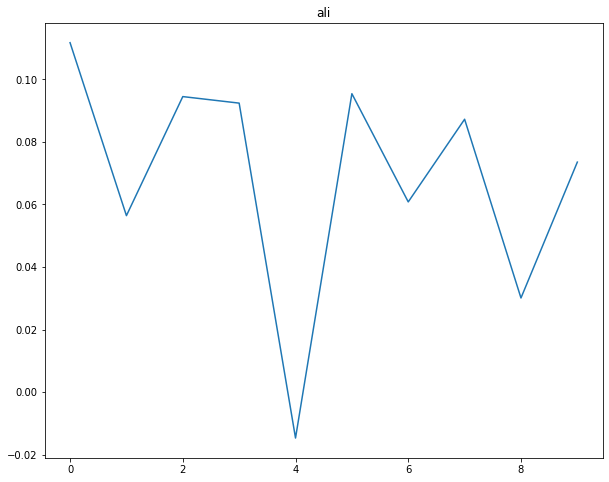

In [174]:
# Show the plot for one comedian
plt.plot(polarity_transcript[0])
plt.title(data['full_name'].index[0])
plt.show()

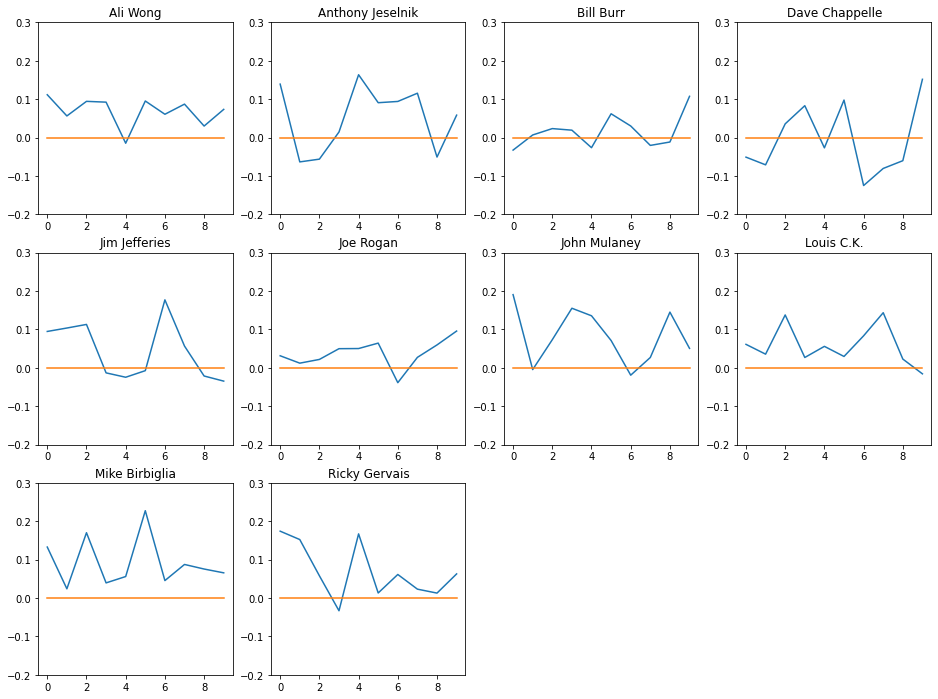

In [175]:
# Show the plot for all comedians
plt.rcParams['figure.figsize'] = [16, 12]

for index, comedian in enumerate(data.index):    
    plt.subplot(3, 4, index+1)
    plt.plot(polarity_transcript[index])
    plt.plot(np.arange(0,10), np.zeros(10))
    plt.title(data['full_name'][index])
    plt.ylim(ymin=-.2, ymax=.3)
    
plt.show()

Ali Wong stays generally positive throughout her routine. Similar comedians are Louis C.K. and Mike Birbiglia.

On the other hand, you have some pretty different patterns here like Bo Burnham who gets happier as time passes and Dave Chappelle who has some pretty down moments in his routine.

# Topic Modeling

## Introduction

Another popular text analysis technique is called topic modeling. The ultimate goal of topic modeling is to find various topics that are present in your corpus. Each document in the corpus will be made up of at least one topic, if not multiple topics.

In this notebook, we will be covering the steps on how to do **Latent Dirichlet Allocation (LDA)**, which is one of many topic modeling techniques. It was specifically designed for text data.

To use a topic modeling technique, you need to provide (1) a document-term matrix and (2) the number of topics you would like the algorithm to pick up.

Once the topic modeling technique is applied, your job as a human is to interpret the results and see if the mix of words in each topic make sense. If they don't make sense, you can try changing up the number of topics, the terms in the document-term matrix, model parameters, or even try a different model.

## Topic Modeling - Attempt #1 (All Text)

In [176]:
# Let's read in our document-term matrix
import pandas as pd
import pickle

data = pd.read_pickle('dtm_stop.pkl')
data

,aaaaah,aaah,aah,abc,abcs,ability,abject,able,ablebodied,abortion,abortions,abroad,absolute,absolutely,absorb,absorbing,abuse,abused,accent,accents,accept,acceptable,accepted,access,accident,accidentally,accomplished,according,accoutrements,accurate,accustomed,achieve,achievement,acid,acknowledge,acknowledging,acquitted,act,acting,actions,...,yeahmy,year,years,yecch,yell,yelled,yelling,yellow,yelp,yep,yes,yesterday,yo,yoga,yoko,yolanda,yolo,york,youd,youi,youll,young,younger,youngest,youth,youtube,youve,yulin,yummy,yyou,ze,zealand,zeppelin,zero,zillion,zombie,zombies,zoning,zoo,éclair
ali,0,0,0,1,0,0,0,2,0,0,0,0,0,0,0,1,1,2,0,0,0,0,0,0,1,1,0,2,0,0,0,2,0,0,0,0,0,1,0,0,...,0,7,5,0,0,0,1,0,1,0,9,0,0,1,1,0,1,0,0,1,4,2,0,0,0,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0
anthony,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,7,5,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,6,0,0,0,0,10,0,0,0,0,0,0,0,0
bill,1,0,0,0,1,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,4,0,0,...,0,3,18,0,0,2,0,1,0,0,3,0,0,1,0,0,0,1,1,0,5,0,0,0,0,1,1,0,1,0,1,0,0,1,1,1,1,1,0,0
dave,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,1,4,0,1,...,0,2,9,0,1,0,0,0,0,0,7,0,1,0,0,0,0,1,7,0,3,10,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
jim,0,0,0,0,0,0,0,1,2,0,0,3,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,2,0,...,0,3,6,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,2,0,2,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,0,0,0,0
joe,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,3,6,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2,0,0,4,0,1,0,3,6,0,0,0,0,0,0,0,0,0,0,0,0,0
john,0,0,0,0,0,0,0,3,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,2,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,...,0,2,11,0,0,1,1,1,0,0,11,0,0,0,0,0,0,7,2,0,1,2,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1
louis,0,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,...,0,3,4,2,0,1,0,0,0,1,12,0,0,0,0,0,0,4,2,0,1,8,3,0,1,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0
mike,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,15,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,2,8,0,0,0,0,0,0,0,2,1,0,0,0,0,0,5,3,0,0,1,0,0,0,0,3,0,0,0,0,0,2,1,0,0,0,0,0,0
ricky,0,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,...,0,10,24,0,0,0,0,0,0,2,14,0,1,0,0,0,0,0,0,0,2,2,0,1,0,1,10,1,1,0,0,0,0,0,0,0,0,0,1,0


In [177]:
# Import the necessary modules for LDA with gensim
# Terminal / Anaconda Navigator: conda install -c conda-forge gensim
from gensim import matutils, models
import scipy.sparse

# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [178]:
# One of the required inputs is a term-document matrix
tdm = data.transpose()
tdm.head()

,ali,anthony,bill,dave,jim,joe,john,louis,mike,ricky
aaaaah,0,0,1,0,0,0,0,0,0,0
aaah,0,0,0,1,0,0,0,0,0,0
aah,0,0,0,0,0,0,0,3,0,0
abc,1,0,0,0,0,0,0,0,0,0
abcs,0,0,1,0,0,0,0,0,0,0


In [179]:
# We're going to put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [180]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term), we need to specify two other parameters - the number of topics and the number of passes. Let's start the number of topics at 2, see if the results make sense, and increase the number from there.

In [181]:
# Now that we have the corpus (term-document matrix) and id2word (dictionary of location: term),
# we need to specify two other parameters as well - the number of topics and the number of passes
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda.print_topics()

[(0,
  '0.013*"said" + 0.006*"time" + 0.005*"didnt" + 0.005*"cause" + 0.004*"really" + 0.004*"says" + 0.004*"oh" + 0.004*"good" + 0.004*"mean" + 0.004*"say"'),
 (1,
  '0.008*"fucking" + 0.007*"shit" + 0.006*"yeah" + 0.006*"theyre" + 0.006*"thing" + 0.006*"said" + 0.005*"say" + 0.005*"day" + 0.005*"hes" + 0.005*"theres"')]

In [182]:
# LDA for num_topics = 3
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda.print_topics()

[(0,
  '0.010*"shit" + 0.009*"yeah" + 0.008*"fucking" + 0.006*"dude" + 0.005*"fuck" + 0.005*"want" + 0.005*"hes" + 0.004*"did" + 0.004*"time" + 0.004*"make"'),
 (1,
  '0.008*"said" + 0.007*"shit" + 0.006*"time" + 0.006*"theyre" + 0.005*"good" + 0.005*"thing" + 0.005*"say" + 0.005*"cause" + 0.005*"didnt" + 0.005*"fucking"'),
 (2,
  '0.013*"said" + 0.007*"yeah" + 0.006*"id" + 0.006*"fucking" + 0.006*"went" + 0.006*"say" + 0.005*"goes" + 0.005*"says" + 0.005*"going" + 0.005*"didnt"')]

In [183]:
# LDA for num_topics = 4
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda.print_topics()

[(0,
  '0.007*"said" + 0.007*"yeah" + 0.007*"hes" + 0.007*"thing" + 0.006*"say" + 0.006*"fucking" + 0.006*"life" + 0.006*"theyre" + 0.006*"theres" + 0.006*"didnt"'),
 (1,
  '0.012*"fucking" + 0.009*"shit" + 0.007*"yeah" + 0.007*"fuck" + 0.006*"day" + 0.006*"went" + 0.006*"going" + 0.006*"want" + 0.006*"oh" + 0.005*"hes"'),
 (2,
  '0.009*"said" + 0.007*"shit" + 0.007*"time" + 0.006*"man" + 0.006*"theyre" + 0.006*"fcking" + 0.005*"didnt" + 0.005*"fck" + 0.005*"oh" + 0.005*"say"'),
 (3,
  '0.015*"said" + 0.006*"says" + 0.006*"say" + 0.005*"cause" + 0.005*"yeah" + 0.005*"really" + 0.005*"day" + 0.005*"goes" + 0.005*"tell" + 0.005*"time"')]

These topics aren't looking too great. We've tried modifying our parameters. Let's try modifying our terms list as well.

## Topic Modeling - Attempt #2 (Nouns Only)

One popular trick is to look only at terms that are from one part of speech (only nouns, only adjectives, etc.). Check out the UPenn tag set: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html.

In [184]:
# Let's create a function to pull out nouns from a string of text
from nltk import word_tokenize, pos_tag

def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [185]:
# Read in the cleaned data, before the CountVectorizer step
data_clean = pd.read_pickle('data_clean.pkl')
data_clean

,transcript
ali,ladies and gentlemen please welcome to the stage ali wong hi hello welcome thank you thank you for coming hello hello we are gonna have to get thi...
anthony,thank you thank you thank you san francisco thank you so much so good to be here people were surprised when i told em i was gonna tape my special ...
bill,all right thank you thank you very much thank you thank you thank you how are you whats going on thank you its a pleasure to be here in the great...
dave,this is dave he tells dirty jokes for a living that stare is where most of his hard work happens it signifies a profound train of thought the alch...
jim,ladies and gentlemen please welcome to the stage mr jim jefferies hello sit down sit down sit down sit down sit down thank you boston i appre...
joe,ladies and gentlemen welcome joe rogan what the fck is going on san francisco thanks for coming i appreciate it god damn put your phone down f...
john,armed with boyish charm and a sharp wit the former snl writer john mulaney offers sly takes on marriage his beef with babies and the time he met b...
louis,introfade the music out lets roll hold there lights do the lights thank you thank you very much i appreciate that i dont necessarily agree with yo...
mike,wow hey thank you thanks thank you guys hey seattle nice to see you look at this look at us were here this is crazy its insane so about five years...
ricky,hello hello how you doing great thank you wow calm down shut the fuck up thank you what a lovely welcome im gonna try my hardest tonight youre thi...


In [186]:
# Apply the nouns function to the transcripts to filter only on nouns
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
data_nouns = pd.DataFrame(data_clean.transcript.apply(nouns))
data_nouns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,transcript
ali,ladies gentlemen stage ali hi thank hello na shit cause i ten minutes thank day year year people uh i im i girl thought im foremost metabolism gir...
anthony,thank thank people i em i francisco city world im stage place cities place bit today baby baby back car day dont monster i baby rock window window...
bill,thank thank pleasure georgia area oasis i june kind heat racism anybody look em drink lemonade man hell life shape man hate gym id week brutal i o...
dave,jokes living stare work profound train thought alchemists transforms levity livelihood trance ♪ workinonit ♪♪ tune ♪♪ ♪ ♪ ♪♪ ahah ♪♪ ghetto ♪♪ aha...
jim,ladies gentlemen stage mr jim jefferies thank thats end tour tour i child ah time home i girlfriend pregnant months life decisions girl i way prob...
joe,ladies gentlemen joe fck thanks phone fckface i phone motherfckers eyes goddamn phone whoo whoo strange i i im move francisco pot people edibles f...
john,charm wit snl writer john mulaney marriage beef babies time bill clinton petunia thats hello hello chicago thank crowd energy show okay thank crow...
louis,music lets lights lights thank i i place place miles direction building shit town sentence i difference sidewalk street pedestrians people kind wa...
mike,wow hey thanks look insane years everyone i idea marriage i problem something source tension person reason source tension im right friend dana mar...
ricky,hello thank fuck thank im gon youre weve moneys legend shut im guy round people sort jesus way show humanity dont i fan i dogs dogs people people ...


In [187]:
# Create a new document-term matrix using only nouns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer

# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.transcript)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aah,abc,abcs,ability,abortion,abortions,abuse,accent,accents,access,accident,accoutrements,achievement,acid,act,acting,actions,activity,actor,actors,ad,adam,adams,address,adjustments,admirers,ads,adult,adults,advance,advantage,adversity,advertising,advice,affair,affection,affirmation,afford,afghan,aframe,...,wrap,wrapping,wrath,wrestlers,writer,writing,wrongness,wutang,xray,ya,yall,yard,yards,yay,yeahmy,year,years,yecch,yelp,yep,yes,yesterday,yoga,yoko,york,youd,youll,youth,youtube,youve,yulin,yummy,ze,zealand,zeppelin,zillion,zombie,zombies,zoo,éclair
ali,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,5,0,1,0,1,0,0,1,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0
anthony,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,7,5,0,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,10,0,0,0,0,0,0
bill,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,6,0,0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,5,0,1,0,0,0,3,17,0,0,0,1,0,1,0,1,0,3,0,1,0,0,0,1,0,0,1,1,1,0,0
dave,0,0,0,0,0,1,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,2,9,0,0,0,2,0,0,0,1,4,1,0,0,1,0,0,0,0,0,0,0,0,0,0
jim,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,1,0,0,3,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,6,0,0,0,1,0,0,0,0,0,1,0,0,7,0,0,0,0,0,0,0,0,0,0
joe,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,3,6,0,0,0,0,0,0,0,0,1,0,0,2,1,0,0,0,0,0,0,0,0,0,0
john,0,0,0,0,0,0,0,1,0,2,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,2,11,0,0,0,4,0,0,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
louis,3,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,3,4,1,0,0,5,0,0,0,4,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0
mike,0,0,0,0,0,0,0,0,0,0,15,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,2,0,0,0,1,0,1,1,0,0,...,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,2,8,0,0,0,0,1,0,0,5,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0
ricky,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,10,24,0,0,1,3,0,0,0,0,0,1,0,1,3,1,1,0,0,0,0,0,0,1,0


In [188]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))

# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [189]:
# Let's start with 2 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=2, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.010*"shit" + 0.009*"cause" + 0.008*"lot" + 0.008*"thing" + 0.008*"life" + 0.007*"man" + 0.007*"day" + 0.007*"way" + 0.006*"gon" + 0.006*"guy"'),
 (1,
  '0.011*"day" + 0.010*"thing" + 0.007*"hes" + 0.006*"man" + 0.006*"guy" + 0.006*"years" + 0.006*"way" + 0.006*"shit" + 0.006*"cause" + 0.005*"life"')]

In [190]:
# Let's try topics = 3
ldan = models.LdaModel(corpus=corpusn, num_topics=3, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.012*"shit" + 0.010*"thing" + 0.009*"life" + 0.009*"man" + 0.009*"day" + 0.009*"hes" + 0.007*"gon" + 0.007*"lot" + 0.007*"cause" + 0.007*"guy"'),
 (1,
  '0.010*"day" + 0.010*"cause" + 0.009*"thing" + 0.007*"guy" + 0.006*"women" + 0.006*"way" + 0.006*"point" + 0.005*"guns" + 0.005*"kind" + 0.005*"night"'),
 (2,
  '0.010*"clinton" + 0.007*"mom" + 0.007*"way" + 0.007*"day" + 0.006*"hey" + 0.006*"cow" + 0.006*"wife" + 0.006*"dad" + 0.005*"house" + 0.005*"cause"')]

In [191]:
# Let's try 4 topics
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.012*"shit" + 0.011*"thing" + 0.010*"life" + 0.009*"lot" + 0.008*"man" + 0.008*"day" + 0.008*"hes" + 0.007*"way" + 0.007*"guy" + 0.007*"women"'),
 (1,
  '0.010*"cause" + 0.009*"way" + 0.008*"house" + 0.008*"kind" + 0.007*"fck" + 0.007*"day" + 0.007*"man" + 0.006*"thing" + 0.006*"gon" + 0.006*"guy"'),
 (2,
  '0.014*"day" + 0.010*"women" + 0.010*"thing" + 0.009*"lot" + 0.009*"cause" + 0.008*"shit" + 0.007*"man" + 0.006*"fuck" + 0.006*"ass" + 0.006*"guns"'),
 (3,
  '0.010*"thing" + 0.009*"hes" + 0.009*"shit" + 0.008*"day" + 0.008*"years" + 0.007*"gon" + 0.007*"joke" + 0.006*"life" + 0.006*"man" + 0.006*"guy"')]

## Topic Modeling - Attempt #3 (Nouns and Adjectives)

In [192]:
# Let's create a function to pull out nouns from a string of text
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [193]:
# Apply the nouns function to the transcripts to filter only on nouns
data_nouns_adj = pd.DataFrame(data_clean.transcript.apply(nouns_adj))
data_nouns_adj

,transcript
ali,ladies gentlemen welcome stage ali wong hi welcome thank hello hello na shit cause i like ten minutes thank much um exciting day exciting year yea...
anthony,thank san francisco thank good people surprised i em i special san francisco correct city world im stage place favorite cities good place little b...
bill,right thank thank pleasure greater atlanta georgia area oasis nice i i june nice wasnt miserable horrible kind heat racism i anybody look em cold ...
dave,dirty jokes living stare most hard work profound train thought alchemists transforms levity livelihood trance ♪ ♪♪ ♪♪ workinonit ♪♪ ♪♪ tune ♪♪ ♪ ♪...
jim,ladies gentlemen welcome stage mr jim jefferies thank i uh thats end tour im happy tour i child ah time home good um i girlfriend pregnant months ...
joe,ladies gentlemen joe fck san francisco thanks i phone fckface i phone motherfckers eyes ta goddamn phone whoo high fck whoo strange i sure i im mo...
john,boyish charm sharp wit former snl writer john mulaney marriage beef babies time bill clinton right petunia august thats good right hello hello chi...
louis,music lets lights lights thank much i i i nice place nicest place many miles direction building shit town sentence odd i difference sidewalk stree...
mike,wow hey thanks hey seattle nice look crazy insane years much everyone married strange i idea marriage fine i problem i right something real source...
ricky,hello great thank fuck thank lovely welcome im gon hardest tonight youre relax weve moneys worth legend shut god im ordinary guy round people sort...


In [194]:
# Create a new document-term matrix using only nouns and adjectives, also remove common words with max_df
cvna = CountVectorizer(stop_words=stop_words, max_df=.8)
data_cvna = cvna.fit_transform(data_nouns_adj.transcript)
data_dtmna = pd.DataFrame(data_cvna.toarray(), columns=cvna.get_feature_names())
data_dtmna.index = data_nouns_adj.index
data_dtmna

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaaah,aah,abc,abcs,ability,abject,able,ablebodied,abortion,abortions,absolute,abuse,accent,accents,acceptable,access,accident,accomplished,accoutrements,accurate,achievement,acid,act,acting,actions,active,activity,actor,actors,actual,ad,adam,adams,address,adjustments,admirers,adorable,ads,adult,adults,...,writer,writing,wrongness,wutang,xray,ya,yall,yard,yards,yay,yeahmy,yecch,yellow,yelp,yep,yes,yesterday,yo,yoga,yoko,york,youd,youll,young,younger,youngest,youth,youtube,youve,yulin,yummy,yyou,ze,zealand,zeppelin,zillion,zombie,zombies,zoo,éclair
ali,0,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,2,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
anthony,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,10,0,0,0,0,0,0
bill,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,6,0,...,0,0,0,0,0,5,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1,0,3,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,0,0
dave,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,2,0,1,0,0,1,4,1,10,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
jim,0,0,0,0,0,0,1,2,0,0,0,0,4,0,0,0,0,0,0,0,0,0,1,1,0,0,0,3,2,1,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2,1,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0
joe,0,0,0,0,0,0,2,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,4,0,1,0,3,1,0,0,0,0,0,0,0,0,0,0,0
john,0,0,0,0,0,0,3,0,0,0,0,0,1,0,1,2,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,...,1,0,0,0,0,0,0,0,0,2,0,0,1,0,0,4,0,0,0,0,7,0,1,2,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1
louis,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,0,0,1,1,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,5,0,0,0,0,4,1,0,8,3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
mike,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,15,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,5,1,0,1,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0
ricky,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,0,0,0,0,0,0,2,2,0,1,0,1,7,1,1,0,0,0,0,0,0,0,1,0


In [195]:
# Create the gensim corpus
corpusna = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmna.transpose()))

# Create the vocabulary dictionary
id2wordna = dict((v, k) for k, v in cvna.vocabulary_.items())

In [196]:
# Let's start with 2 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=2, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.005*"joke" + 0.004*"fck" + 0.004*"kid" + 0.003*"mom" + 0.003*"friend" + 0.003*"different" + 0.003*"fuck" + 0.003*"ahah" + 0.003*"okay" + 0.003*"parents"'),
 (1,
  '0.008*"fuck" + 0.007*"fucking" + 0.006*"dude" + 0.005*"kid" + 0.004*"ass" + 0.004*"everybody" + 0.004*"gun" + 0.004*"ok" + 0.003*"guns" + 0.003*"men"')]

In [197]:
# Let's try 3 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=3, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.009*"fuck" + 0.007*"fucking" + 0.005*"dude" + 0.005*"ahah" + 0.005*"joke" + 0.004*"kid" + 0.004*"everybody" + 0.003*"gay" + 0.003*"nuts" + 0.003*"water"'),
 (1,
  '0.006*"clinton" + 0.006*"jenny" + 0.005*"parents" + 0.005*"friend" + 0.004*"mom" + 0.004*"cow" + 0.004*"wife" + 0.004*"john" + 0.003*"phone" + 0.003*"sure"'),
 (2,
  '0.006*"fck" + 0.006*"kid" + 0.005*"fuck" + 0.004*"men" + 0.004*"dude" + 0.004*"ass" + 0.004*"different" + 0.004*"joke" + 0.004*"girl" + 0.004*"everybody"')]

In [198]:
# Let's try 4 topics
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=10)
ldana.print_topics()

[(0,
  '0.008*"husband" + 0.007*"ok" + 0.006*"pregnant" + 0.005*"dude" + 0.004*"uh" + 0.004*"asian" + 0.004*"fingers" + 0.004*"doo" + 0.004*"mom" + 0.004*"wan"'),
 (1,
  '0.006*"fck" + 0.005*"ahah" + 0.004*"friend" + 0.004*"clinton" + 0.004*"mom" + 0.004*"different" + 0.004*"jenny" + 0.004*"wife" + 0.003*"parents" + 0.003*"dude"'),
 (2,
  '0.010*"fucking" + 0.009*"fuck" + 0.006*"joke" + 0.005*"kid" + 0.005*"dude" + 0.005*"gun" + 0.004*"guns" + 0.004*"ass" + 0.004*"hell" + 0.003*"class"'),
 (3,
  '0.009*"joke" + 0.007*"anthony" + 0.007*"course" + 0.006*"tit" + 0.005*"kid" + 0.005*"grandma" + 0.004*"shark" + 0.004*"ok" + 0.004*"family" + 0.004*"jokes"')]

## Identify Topics in Each Document

Out of the 9 topic models we looked at, the nouns and adjectives, 4 topic one made the most sense. So let's pull that down here and run it through some more iterations to get more fine-tuned topics.

In [199]:
# Our final LDA model (for now)
ldana = models.LdaModel(corpus=corpusna, num_topics=4, id2word=id2wordna, passes=80)
ldana.print_topics()

[(0,
  '0.006*"fck" + 0.006*"fuck" + 0.005*"fucking" + 0.005*"men" + 0.005*"ahah" + 0.005*"kid" + 0.004*"different" + 0.004*"girl" + 0.004*"ass" + 0.004*"wife"'),
 (1,
  '0.008*"husband" + 0.007*"ok" + 0.006*"pregnant" + 0.005*"dude" + 0.004*"uh" + 0.004*"asian" + 0.004*"fingers" + 0.004*"doo" + 0.004*"mom" + 0.004*"wan"'),
 (2,
  '0.011*"joke" + 0.007*"fuck" + 0.007*"fucking" + 0.006*"kid" + 0.005*"dude" + 0.004*"jokes" + 0.004*"family" + 0.004*"anthony" + 0.004*"hell" + 0.004*"gun"'),
 (3,
  '0.007*"jenny" + 0.005*"course" + 0.005*"tit" + 0.004*"date" + 0.004*"accident" + 0.004*"sure" + 0.004*"phone" + 0.004*"parents" + 0.003*"worst" + 0.003*"morning"')]

These four topics look pretty decent. Let's settle on these for now.
* Topic 0: mom, parents
* Topic 1: husband, wife
* Topic 2: guns
* Topic 3: profanity

In [200]:
# Let's take a look at which topics each transcript contains
corpus_transformed = ldana[corpusna]
list(zip([a for [(a,b)] in corpus_transformed], data_dtmna.index))

[(1, 'ali'),
 (2, 'anthony'),
 (2, 'bill'),
 (0, 'dave'),
 (0, 'jim'),
 (0, 'joe'),
 (0, 'john'),
 (3, 'louis'),
 (3, 'mike'),
 (2, 'ricky')]

For a first pass of LDA, these kind of make sense to me, so we'll call it a day for now.
* Topic 0: mom, parents [Anthony, Hasan, Louis, Ricky]
* Topic 1: husband, wife [Ali, John, Mike]
* Topic 2: guns [Bill, Bo, Jim]
* Topic 3: profanity [Dave, Joe]

# Text Generation

## Introduction

Markov chains can be used for very basic text generation. Think about every word in a corpus as a state. We can make a simple assumption that the next word is only dependent on the previous word - which is the basic assumption of a Markov chain.

Markov chains don't generate text as well as deep learning, but it's a good (and fun!) start.

## Select Text to Imitate

In this notebook, we're specifically going to generate text in the style of Ali Wong, so as a first step, let's extract the text from her comedy routine.

In [201]:
# Read in the corpus, including punctuation!
import pandas as pd

data = pd.read_pickle('corpus.pkl')
data

,transcript,full_name
ali,"Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have ...",Ali Wong
anthony,"Thank you. Thank you. Thank you, San Francisco. Thank you so much. So good to be here. People were surprised when I told ’em I was gonna tape my s...",Anthony Jeselnik
bill,"[cheers and applause] All right, thank you! Thank you very much! Thank you. Thank you. Thank you. How are you? What’s going on? Thank you. It’s a ...",Bill Burr
dave,"This is Dave. He tells dirty jokes for a living. That stare is where most of his hard work happens. It signifies a profound train of thought, the ...",Dave Chappelle
jim,"[Car horn honks] [Audience cheering] [Announcer] Ladies and gentlemen, please welcome to the stage Mr. Jim Jefferies! [Upbeat music playing] Hello...",Jim Jefferies
joe,"[rock music playing] [audience cheering] [announcer] Ladies and gentlemen, welcome Joe Rogan. [audience cheering and applauding] What the f*ck is ...",Joe Rogan
john,"Armed with boyish charm and a sharp wit, the former “SNL” writer John Mulaney offers sly takes on marriage, his beef with babies and the time he m...",John Mulaney
louis,Intro\nFade the music out. Let’s roll. Hold there. Lights. Do the lights. Thank you. Thank you very much. I appreciate that. I don’t necessarily a...,Louis C.K.
mike,"Wow. Hey, thank you. Thanks. Thank you, guys. Hey, Seattle. Nice to see you. Look at this. Look at us. We’re here. This is crazy. It’s insane. So ...",Mike Birbiglia
ricky,Hello. Hello! How you doing? Great. Thank you. Wow. Calm down. Shut the fuck up. Thank you. What a lovely welcome. I’m gonna try my hardest tonigh...,Ricky Gervais


In [202]:
# Extract only Ali Wong's text
ali_text = data.transcript.loc['ali']
ali_text[:200]

'Ladies and gentlemen, please welcome to the stage: Ali Wong! Hi. Hello! Welcome! Thank you! Thank you for coming. Hello! Hello. We are gonna have to get this shit over with, ’cause I have to pee in, l'

## Build a Markov Chain Function

We are going to build a simple Markov chain function that creates a dictionary:
* The keys should be all of the words in the corpus
* The values should be a list of the words that follow the keys

In [203]:
from collections import defaultdict

def markov_chain(text):
    '''The input is a string of text and the output will be a dictionary with each word as
       a key and each value as the list of words that come after the key in the text.'''
    
    # Tokenize the text by word, though including punctuation
    words = text.split(' ')
    
    # Initialize a default dictionary to hold all of the words and next words
    m_dict = defaultdict(list)
    
    # Create a zipped list of all of the word pairs and put them in word: list of next words format
    for current_word, next_word in zip(words[0:-1], words[1:]):
        m_dict[current_word].append(next_word)

    # Convert the default dict back into a dictionary
    m_dict = dict(m_dict)
    return m_dict

In [204]:
# Create the dictionary for Ali's routine, take a look at it
ali_dict = markov_chain(ali_text)
ali_dict

{'Ladies': ['and'],
 'and': ['gentlemen,',
  'foremost,',
  'then',
  'have',
  'there’s',
  'resentment',
  'get',
  'get',
  'says,',
  'my',
  'she',
  'snatch',
  'running',
  'fighting',
  'yelling',
  'it',
  'she',
  'I',
  'I',
  'I',
  'we',
  'watched',
  'I',
  'have',
  'that',
  'recycling,',
  'disturbing',
  'it’s',
  'all',
  'just…',
  'be',
  'half-Vietnamese.',
  'his',
  'slide.',
  'your',
  'inflamed',
  'you’re',
  'I',
  'half-Japanese',
  'I’m',
  'half-Vietnamese.',
  'playing',
  'rugby.',
  'foremost,',
  'a',
  'emotionally',
  'I',
  '20',
  'neither',
  'I',
  'I–',
  'then',
  'it’s',
  'find',
  'start',
  'just',
  'caves',
  'gets',
  'is',
  'very',
  'for',
  'I',
  'she',
  'rise',
  'be',
  'eat',
  'watch',
  'be',
  'now',
  'most',
  'in',
  'then',
  'digitally',
  'then',
  'then',
  'then',
  'steady',
  'brings',
  'let',
  'reverberate',
  'say,',
  'my',
  'he',
  'when',
  'I’m',
  'sicker,',
  'sicker.',
  'sicker,',
  'sicker,',
  'pos

## Create a Text Generator

We're going to create a function that generates sentences. It will take two things as inputs:
* The dictionary you just created
* The number of words you want generated

Here are some examples of generated sentences:

>'Shape right turn– I also takes so that she’s got women all know that snail-trail.'

>'Optimum level of early retirement, and be sure all the following Tuesday… because it’s too.'

In [205]:
import random

def generate_sentence(chain, count=15):
    '''Input a dictionary in the format of key = current word, value = list of next words
       along with the number of words you would like to see in your generated sentence.'''

    # Capitalize the first word
    word1 = random.choice(list(chain.keys()))
    sentence = word1.capitalize()

    # Generate the second word from the value list. Set the new word as the first word. Repeat.
    for i in range(count-1):
        word2 = random.choice(chain[word1])
        word1 = word2
        sentence += ' ' + word2

    # End it with a period
    sentence += '.'
    return(sentence)

In [206]:
generate_sentence(ali_dict)

'Hi. Hello! Welcome! Thank you. I grew up soldier glue, when he was in the.'